<a href="https://colab.research.google.com/github/AdairGarcia/Semillero-IA-hitss/blob/main/Evaluacion/EjercicioFinalML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
import os


In [145]:
# Cargar dataframe
extract_path = '/content/south_german_credit_data'
data_file_path = os.path.join(extract_path, 'SouthGermanCredit.asc')
df = pd.read_csv(data_file_path, delim_whitespace=True)
# Cambiar columnas
column_names_mapping = {
    'laufkont': 'status',
    'laufzeit': 'duration',
    'moral': 'credit_history',
    'verw': 'purpose',
    'hoehe': 'amount',
    'sparkont': 'savings',
    'beszeit': 'employment_duration',
    'rate': 'installment_rate',
    'famges': 'personal_status_sex',
    'buerge': 'other_debtors',
    'wohnzeit': 'present_residence',
    'verm': 'property',
    'alter': 'age',
    'weitkred': 'other_installment_plans',
    'wohn': 'housing',
    'bishkred': 'number_credits',
    'beruf': 'job',
    'pers': 'people_liable',
    'telef': 'telephone',
    'gastarb': 'foreign_worker',
    'kredit': 'credit_risk'
}
df.rename(columns=column_names_mapping, inplace=True)


/tmp/ipython-input-881742315.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(data_file_path, delim_whitespace=True)


In [146]:
# X seran todas las caracteristicas menos el credito
X = df.drop('credit_risk', axis=1)
# Y es el credito
Y = df['credit_risk']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

print("Dimensiones del conjunto de entrenamiento (X_train, Y_train):", X_train.shape, Y_train.shape)
print("Dimensiones del conjunto de prueba (X_test, Y_test):", X_test.shape, Y_test.shape)

Dimensiones del conjunto de entrenamiento (X_train, Y_train): (850, 20) (850,)
Dimensiones del conjunto de prueba (X_test, Y_test): (150, 20) (150,)


In [147]:
#Categorica
categorical_cols = [
    'status',
    'credit_history',
    'purpose',
    'savings',
    'personal_status_sex',
    'other_debtors',
    'other_installment_plans',
    'housing',
]

# Ordinal
ordinal_cols = [
    'employment_duration',
    'installment_rate',
    'present_residence',
    'property',
    'number_credits',
    'job',
]

# Numerica
quantitative_cols = [
    'duration',
    'amount',
    'age',
    'people_liable'
]

# Binaria
binary_cols = [
    'telephone',
    'foreign_worker'
]


In [148]:
# Numerica: Mediana para mantener la distribución
quantitative_imputer = SimpleImputer(strategy='median')
# Categorica: Moda para tener la categoria mas comun
categorical_ordinal_binary_imputer = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()
# Ordinal y binaria: Moda para mantener el orden y saber el binario mas usado
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

preprocessing_steps = {
    'quantitative': [('imputer', quantitative_imputer), ('scaler', scaler)],
    'categorical': [('imputer', categorical_ordinal_binary_imputer), ('encoder', one_hot_encoder)],
    'ordinal': [('imputer', categorical_ordinal_binary_imputer)],
    'binary': [('imputer', categorical_ordinal_binary_imputer), ('encoder', one_hot_encoder)]
}



In [149]:
# Pipelines para las columnas
quantitative_pipeline = Pipeline(steps=preprocessing_steps['quantitative'])
categorical_pipeline = Pipeline(steps=preprocessing_steps['categorical'])
ordinal_pipeline = Pipeline(steps=preprocessing_steps['ordinal'])
binary_pipeline = Pipeline(steps=preprocessing_steps['binary'])

# Pasar los pipelines a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('quantitative', quantitative_pipeline, quantitative_cols),
        ('categorical', categorical_pipeline, categorical_cols),
        ('ordinal', ordinal_pipeline, ordinal_cols),
        ('binary', binary_pipeline, binary_cols)
    ],
    remainder='drop'
)

# Datos de entranamiento con los procesos aplicados
X_train_transformed = preprocessor.fit_transform(X_train)

print("X_train_transformed shape:", X_train_transformed.shape)

X_train_transformed shape: (850, 51)


In [150]:
# Calcula accuracy, precision, recall, f1-score, Gmean

def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    gmean = np.sqrt(recall * specificity) if recall * specificity >= 0 else 0


    return accuracy, precision, recall, f1, gmean

In [151]:
n_splits = 5
n_repeats = 3
random_state = 42

# Validacion cruzada
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

print(f"RepeatedStratifiedKFold con {n_splits} splits y {n_repeats} repeticiones.")

RepeatedStratifiedKFold con 5 splits y 3 repeticiones.


In [152]:
model = LogisticRegression(max_iter=1000)

full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

print("Pipeline definitivo ")

Pipeline definitivo 


In [153]:
# Variables para guardar metricas
train_accuracy_scores = []
val_accuracy_scores = []
train_precision_scores = []
val_precision_scores = []
train_recall_scores = []
val_recall_scores = []
train_f1_scores = []
val_f1_scores = []
train_gmean_scores = []
val_gmean_scores = []

for fold, (train_index, val_index) in enumerate(rskf.split(X, Y)):
    print(f"Processing Fold {fold + 1}")

    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    Y_train_fold, Y_val_fold = Y.iloc[train_index], Y.iloc[val_index]

    full_pipeline.fit(X_train_fold, Y_train_fold)

    Y_train_pred = full_pipeline.predict(X_train_fold)
    Y_val_pred = full_pipeline.predict(X_val_fold)

    train_accuracy, train_precision, train_recall, train_f1, train_gmean = calculate_metrics(Y_train_fold, Y_train_pred)
    val_accuracy, val_precision, val_recall, val_f1, val_gmean = calculate_metrics(Y_val_fold, Y_val_pred)

    # Guardar metricas
    train_accuracy_scores.append(train_accuracy)
    val_accuracy_scores.append(val_accuracy)
    train_precision_scores.append(train_precision)
    val_precision_scores.append(val_precision)
    train_recall_scores.append(train_recall)
    val_recall_scores.append(val_recall)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)
    train_gmean_scores.append(train_gmean)
    val_gmean_scores.append(val_gmean)


Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4
Processing Fold 5
Processing Fold 6
Processing Fold 7
Processing Fold 8
Processing Fold 9
Processing Fold 10
Processing Fold 11
Processing Fold 12
Processing Fold 13
Processing Fold 14
Processing Fold 15


In [154]:
# Calcular desviacion estandar y promedio de los datos de entrenamiento
mean_train_accuracy = np.mean(train_accuracy_scores)
std_train_accuracy = np.std(train_accuracy_scores)
mean_train_precision = np.mean(train_precision_scores)
std_train_precision = np.std(train_precision_scores)
mean_train_recall = np.mean(train_recall_scores)
std_train_recall = np.std(train_recall_scores)
mean_train_f1 = np.mean(train_f1_scores)
std_train_f1 = np.std(train_f1_scores)
mean_train_gmean = np.mean(train_gmean_scores)
std_train_gmean = np.std(train_gmean_scores)

# Lo mismo para valores reales
mean_val_accuracy = np.mean(val_accuracy_scores)
std_val_accuracy = np.std(val_accuracy_scores)
mean_val_precision = np.mean(val_precision_scores)
std_val_precision = np.std(val_precision_scores)
mean_val_recall = np.mean(val_recall_scores)
std_val_recall = np.std(val_recall_scores)
mean_val_f1 = np.mean(val_f1_scores)
std_val_f1 = np.std(val_f1_scores)
mean_val_gmean = np.mean(val_gmean_scores)
std_val_gmean = np.std(val_gmean_scores)

print("Resultados entrenamiento (Mean ± Std Dev):")
print(f"  Accuracy: {mean_train_accuracy:.4f} ± {std_train_accuracy:.4f}")
print(f"  Precision: {mean_train_precision:.4f} ± {std_train_precision:.4f}")
print(f"  Recall: {mean_train_recall:.4f} ± {std_train_recall:.4f}")
print(f"  F1-score: {mean_train_f1:.4f} ± {std_train_f1:.4f}")
print(f"  Gmean: {mean_train_gmean:.4f} ± {std_train_gmean:.4f}")
print("\nResultados validacion (Mean ± Std Dev):")
print(f"  Accuracy: {mean_val_accuracy:.4f} ± {std_val_accuracy:.4f}")
print(f"  Precision: {mean_val_precision:.4f} ± {std_val_precision:.4f}")
print(f"  Recall: {mean_val_recall:.4f} ± {std_val_recall:.4f}")
print(f"  F1-score: {mean_val_f1:.4f} ± {std_val_f1:.4f}")
print(f"  Gmean: {mean_val_gmean:.4f} ± {std_val_gmean:.4f}")

Resultados entrenamiento (Mean ± Std Dev):
  Accuracy: 0.7858 ± 0.0065
  Precision: 0.8162 ± 0.0057
  Recall: 0.8957 ± 0.0058
  F1-score: 0.8541 ± 0.0043
  Gmean: 0.6884 ± 0.0117

Resultados validacion (Mean ± Std Dev):
  Accuracy: 0.7547 ± 0.0177
  Precision: 0.7978 ± 0.0194
  Recall: 0.8714 ± 0.0304
  F1-score: 0.8325 ± 0.0128
  Gmean: 0.6456 ± 0.0436


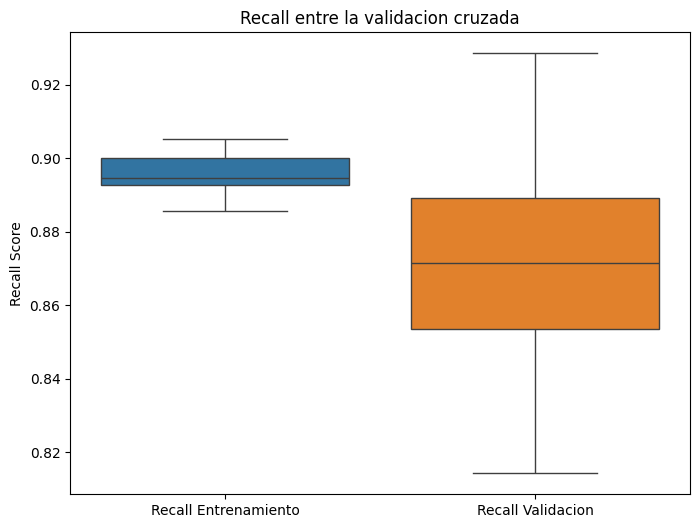

In [155]:
# Mostrar resultados
recall_scores_for_plot = [train_recall_scores, val_recall_scores]
plt.figure(figsize=(8, 6))
sns.boxplot(data=recall_scores_for_plot)

plt.xticks([0, 1], ['Recall Entrenamiento', 'Recall Validacion'])
plt.ylabel('Recall Score')
plt.title('Recall entre la validacion cruzada')

plt.show()

In [156]:
# Mostrar resultados
print(f"Promedio del Accuracy Entrenamiento: {mean_train_accuracy:.4f} ± {std_train_accuracy:.4f}")
print(f"Promedio del Accuracy Validación: {mean_val_accuracy:.4f} ± {std_val_accuracy:.4f}")
print("-" * 30)
print(f"Promedio del Recall Entrenamiento: {mean_train_recall:.4f} ± {std_train_recall:.4f}")
print(f"Promedio del Recall Validación: {mean_val_recall:.4f} ± {std_val_recall:.4f}")
print("-" * 30)
print(f"Promedio del F1-score Entrenamiento: {mean_train_f1:.4f} ± {std_train_f1:.4f}")
print(f"Promedio del F1-score Validación: {mean_val_f1:.4f} ± {std_val_f1:.4f}")
print("-" * 30)
print(f"Promedio del Gmean Entrenamiento: {mean_train_gmean:.4f} ± {std_train_gmean:.4f}")
print(f"Promedio del Gmean Validación: {mean_val_gmean:.4f} ± {std_val_gmean:.4f}")
print("-" * 30)



Promedio del Accuracy Entrenamiento: 0.7858 ± 0.0065
Promedio del Accuracy Validación: 0.7547 ± 0.0177
------------------------------
Promedio del Recall Entrenamiento: 0.8957 ± 0.0058
Promedio del Recall Validación: 0.8714 ± 0.0304
------------------------------
Promedio del F1-score Entrenamiento: 0.8541 ± 0.0043
Promedio del F1-score Validación: 0.8325 ± 0.0128
------------------------------
Promedio del Gmean Entrenamiento: 0.6884 ± 0.0117
Promedio del Gmean Validación: 0.6456 ± 0.0436
------------------------------


La precisión del entrenamiento es significativamente mayor que la de la validación. Por otro lado la recuperación del entrenamiento y la validación son relativamente similares, y la puntuación F1 del entrenamiento es significativamente mayor que la de la validación.

Estos nos lleva a que el rendimiento del modelo en los conjuntos de entrenamiento y validación es relativamente consistente. Ya que las métricas de rendimiento en los conjuntos de entrenamiento y validación son similares, lo que sugiere que el modelo se generaliza razonablemente bien. Puede haber una ligera diferencia, pero esto no indica un sobreajuste o subajuste grave según los umbrales elegidos.